In [0]:
# LIBRERIAS NECESARIAS

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from IPython.display import clear_output
import os


In [0]:
# SE SELECCIONA LA VERSION 2.X DE TENSORFLOW
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# CONEXION CON GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# PREPARACION DE DATASET

MAINPATH = '/content/drive/My Drive/comicPix2Pix/'
INPATH = 'input/'
TARGPATH = 'target/'
OUTPATH = 'output/'
CKPATH = 'checkpoints/'

imgurls = !ls -1 "{MAINPATH+INPATH}"
print(imgurls)


#dataset
n = 400
train_n = round(n * 0.90) # training set 90%

# listado randomizado.
randurls = np.copy(imgurls)

# no tiene mucho sentido en este caso realizar random de las fotos, no tienen ninguna secuencia
#np.random.seed(20) #seed aleatorio, el random a continuacion sera igual para todas las ejecuciones
#np.random.shuffle(randurls)

# Partición train/test
tr_urls = randurls[:train_n] # de principio hasta train_n (80%)
ts_urls = randurls[train_n:n] # desde train_n hasta el final n

print( len(imgurls), len(tr_urls), len(ts_urls))
print(ts_urls)

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  
  return inimg, tgimg

# Normalizar datos de imagen al rango [-1,+1]
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1
  
  return inimg,tgimg

# Aumento de datos: Random Crop + Flip - Recomendado por pix2pix

def random_jitter(inimg, tgimg):
  inimg, tgimg = resize(inimg, tgimg, 256, 256)
  
  stacked_image = tf.stack([inimg,tgimg], axis = 0) # superpone imagenes, para realizar la misma operacion luego sobre ambas
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]) 
  
  inimg, tgimg = cropped_image[0], cropped_image[1]  # se recuperan imagenes
  
  
  randomNumber = tf.random.uniform(())
  inimg = tf.cond( randomNumber > 0.5, lambda: tf.image.flip_left_right(inimg), lambda: inimg)
  tgimg = tf.cond( randomNumber > 0.5, lambda: tf.image.flip_left_right(tgimg), lambda: tgimg)
  #if tf.random_uniform(()) > 0.5:                   # aleatoriamente a izq o a derecha
  #  inimg = tf.image.flip_left_right(inimg)
  #  tgimg = tf.image.flip_left_right(tgimg)
   
  return inimg, tgimg

# Cargar imagenes
def load_image(filename, augment = True):
  
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(MAINPATH + INPATH + filename)), tf.float32)[..., :3]  # float para poder normalizar luego entre -1 a + 
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(MAINPATH + TARGPATH + filename)), tf.float32)[..., :3] # [..., :3] limitar ultima dimension a 3
  
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
    
  #inimg, tgimg  = tf.cond( augment < 2, lambda: random_jitter(inimg, tgimg), lambda: inimg, tgimg) # me da error,pred must not be a Python bool', True)
  
  inimg, tgimg = normalize(inimg, tgimg)
  
  return inimg, tgimg

# Para entrenar   

def load_train_image(filename):
  return load_image(filename , True)


# Para predecir, creo.
def load_test_image(filename):
  return load_image(filename , False)

In [0]:

train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls) # fuente de datos
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # mapear con funcion load_train_image y tensorflow administra hilos y nucleos
train_dataset = train_dataset.batch(1) # tamaño de lote, segun paper

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls) # fuente de datos
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # mapear con funcion load_train_image y tensorflow administra hilos y nucleos
test_dataset = test_dataset.batch(1) # tamaño de lote, segun paper

In [0]:
# bloque neuronal

def downsample(filters, apply_batchnorm=True):
  
  result = Sequential() # resultado sera secuencia de capas
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  #Capa convolucional
  result.add(Conv2D(filters,         # datos segun paper "apendix"
                   kernel_size=4,
                   strides=2,
                   padding="same",
                   kernel_initializer=initializer,
                   use_bias=not apply_batchnorm))
  
  #Capa de batch  normalization
  if apply_batchnorm:
    result.add(BatchNormalization())
  
  #Capa de activacion
  result.add(LeakyReLU())
  
  return result

downsample(64)

In [0]:
# bloque neuronal

def upsample(filters, apply_dropout=False):
  
  result = Sequential() # resultado sera secuencia de capas
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  #Capa convolucional
  result.add(Conv2DTranspose(filters,         # datos segun paper "apendix"
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))
  
  #Capa de batch  normalization
  result.add(BatchNormalization())
  
  # Capa dropout
  if apply_dropout:
    result.add(Dropout(0.5))

  #Capa de activacion
  result.add(ReLU())
  
  return result

upsample(64)

In [0]:
# < Generador >

def Generator():
  
  inputs = tf.keras.layers.Input(shape=[None,None,3]) # se deja abierto width y height, pero 3 canales de color
  
  # Declaramos los bloques de la red, no se conecta nada aun
  down_stack = [                                #   dimensiones por capa si entra 256 x 256, la ultima dimension es segun el filtro
      downsample(64, apply_batchnorm=False),    # (bs, 128, 128,  64)   ENCODER 
      downsample(128),                          # (bs,  64,  64, 128)
      downsample(256),                          # (bs,  32,  32, 256)
      downsample(512),                          # (bs,  16,  16, 512)
      downsample(512),                          # (bs,   8,   8, 512)
      downsample(512),                          # (bs,   4,   4, 512)
      downsample(512),                          # (bs,   2,   2, 512)
      downsample(512),                          # (bs,   1,   1, 512)
  ]
  
  up_stack = [                                  #   dimensiones por capa si entra 256 x 256, la ultima dimension es segun el filtro
      upsample(512, apply_dropout=True),        # (bs,  2,   2, 1024)   DECODER
      upsample(512, apply_dropout=True),        # (bs,  4,   4, 1024)
      upsample(512, apply_dropout=True),        # (bs,  8,   8, 1024)
      upsample(512),                            # (bs,  16, 16, 1024)
      upsample(256),                            # (bs,  32, 32,  512)
      upsample(128),                            # (bs,  64, 64,  256)
      upsample(64),                             # (bs, 128,128,  128)
  ]
  
  #Ultima capa, para que de como resultado la imagen esperada
  
  initializer = tf.random_normal_initializer(0, 0.02)
  last = Conv2DTranspose(filters = 3,      # 3 canales (RGB)
                         kernel_size = 4, # paper
                         strides = 2,     # para duplicar px y llegar a 256x256
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")  #porque imagenes vienen con valores -1 a 1
  

  
  # procesamiento de capas, conectamos las capas. decoder --> encoder  (reloj de arena))
  
  x = inputs
  s =[]   # skip connections
  concat = Concatenate()
  
  for down in down_stack:
    x = down(x)
    s.append(x)
    
  s = reversed(s[:-1])  # hasta penultimo elemento y lo invierto, porque ultimo resultado de decoder se aplica a encoder
  
  for up, sk in zip(up_stack, s):  # concatena capas de decoder con las del encoder
    x = up(x)
    x = concat([x,sk])
    
  # ultima capa  
  last = last(x)
  
  return Model(inputs=inputs, outputs=last)

generator = Generator()

In [0]:
# una red patchgan es una red convolucional, evalua zonas y va determinando si son reales o no
# en vez de devolver un resultado si o no, devuelve una matricula que indica las zonas que parecen ciertas o no

def Discriminator():

  ini = Input(shape=[None,None,3], name="input_img")
  gen = Input(shape=[None,None,3], name="gener_img")
  
  con = concatenate([ini, gen]) # nos devuelve tensor 256x256x6
  
  initializer = tf.random_normal_initializer(0,0.02)
  
  down1 = downsample(64, apply_batchnorm=False)(con)    # segun paper
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)
  
  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)
  
  return tf.keras.Model(inputs=[ini,gen], outputs=last)

discriminator = Discriminator()

In [0]:
# Funcion de Coste

#para evaluar resultados de imagenes obtenidas
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # calcula entropia cruzada de pixeles que se obtienen, from_logits normalizar con sigmoid


In [0]:
# evaluacion de comportamiento de discriminador

def discriminator_loss(disc_real_output, disc_generated_output):
  
  #Diferencia entre los true por ser real y el detectado por el discriminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)   # ones_likes seria perfecto
  
  #Diferencia enter los false por ser generado y el detectado por el discriminador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)   # zeros_like seria nada concuerda
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [0]:
# evaluacion de comportamiento del genrador

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  
  #   error que indica el discriminador, lo engaña?
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  #mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output)) # error absoluto medio de imagenes
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss) # lamba pone mas peso al error l1_loss que al adversario
  
  return total_gen_loss

In [0]:
import os

# definicion de optimizadores
generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#checkpoint para guardar épocas
checkpoint_prefix = os.path.join(MAINPATH + CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

# DESCOMENTAR PARA RESTAURAR CHECKPOINT
#checkpoint.restore(tf.train.latest_checkpoint(MAINPATH+CKPATH)) #.assert_consumed()

In [0]:
# PARA IR EVALUANDO EL COMPORTAMIENTO DEL MODELO GENERADOR 

def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  
  #le paso al generador imagenes del set de prueba
  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(MAINPATH + OUTPATH + save_filename + '.png', prediction[0,...])
  
  plt.figure(figsize=(10,10))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  tittle = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1,3,i+1)
      plt.title(tittle[i])
      #getting the pixel values between [0,1] to plot it
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
      
  plt.show()

In [0]:
# ENTRENAMIENTO

@tf.function()   # decora funcion y las subyacentes, ejecuta el sistema optimizando

def train_step(input_image, target):
  
  #auto diferenciacion, para acceder a gradientes y optimizar los pesos
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
  
    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr) # funcion de costo de discriminador

    gen_loss = generator_loss(output_gen_discr, output_image, target)  # funcion de coste del generador

    #gradientes
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
    
    #aplicar
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))
  
  

In [0]:
# RUTINA DE ENTRENAMIENTO


def train(dataset, epochs):
  
  for epoch in range(epochs):
    imgi = 0
    for input_image, target in dataset:
      print('epoch' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)
    
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      
    # saving checkpoint of the model every 50 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
# LET'S TRAIN !!!

train(train_dataset, 100)

In [0]:
# GENERAR OUTPUTS PARA TEST DATASET


imgi=0
for inp, tar in test_dataset.take(20):
  
    generate_images(generator, inp, tar, 'imagen_0'+str(imgi), display_imgs=True)
    imgi=imgi+1

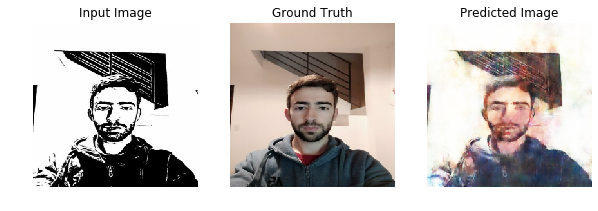

In [0]:
# Prediccion de una imagen nueva, debe existir en INPATH y en TARGPATH

predictions_urls = []
predictions_urls.append('sample__401.jpg')


new_dataset = tf.data.Dataset.from_tensor_slices(predictions_urls) # fuente de datos
new_dataset = new_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # mapear con funcion load_train_image y tensorflow administra hilos y nucleos
new_dataset = new_dataset.batch(1) # tamaño de lote, segun paper

imgi=0
for inp, tar in new_dataset.take(1):
    generate_images(generator, inp, tar, '400img_0'+str(imgi), display_imgs=True)
    imgi=imgi+1